# TOA radiation evaluation for nextGEMS production

contributed by Sebastian Milinski (sebastian.milinski@ecmwf.int) and modified by Tobias Becker (tobias.becker@ecmwf.int), based on [STARTHERE_IFS.ipynb](./STARTHERE_IFS.ipynb)

- simple monitoring for IFS-FESOM 10km production
- reference datasets: CERES (radiation), ERA5 (temperature)

In [1]:
# uncomment below if you see a gribscan module not found error
#!pip install gribscan

In [39]:
#1)uncomment below to install the hackathon python environment (only needed once). 
#2)After installing, refresh the jupyter browser and select as kernel the newly installed one (click on top-right, look for python-HH-hackathon-cdo)
#3)You can then comment this line again
#!module use /work/k20200/k202134/hsm-tools/outtake/module; module rm python3; module load python3/hamburg-hackathon; install_kernel --cdo /sw/spack-levante/cdo-2.3.0-mck3wy/bin/cdo --kernel_name python-hh-hackathon-cdo 

Loading python3/hamburg-hackathon
  Loading requirement: cdo/2.2.2-gcc-11.2.0
>WARNING:root:calling python -m ipykernel install --name python-hh-hackathon-cdo --user
Installed kernelspec python-hh-hackathon-cdo in /home/u/u233156/.local/share/jupyter/kernels/python-hh-hackathon-cdo


In [36]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import matplotlib.cm as cm
import cmocean.cm as cmo
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
import gribscan
import intake
# Import Cdo-py
import cdo
cdo = cdo.Cdo(tempdir='/scratch/u/u233156/tmp/cdo-py') #change the tempdir to your scratch

import cartopy.crs as ccrs
import calendar # convert month numbers into month name strings with calendar.month_name[1] => 'January'
# all-caps month abbr: calendar.month_abbr[1].upper() => 'JAN'

import os

plotdir = './plots/'
if not os.path.exists(plotdir):
    os.makedirs(plotdir)

In [2]:
def attach_coords(ds):
    model_lon = ds.lon.values
    model_lat = ds.lat.values
    return ds.assign_coords(
        lat = (("value",), model_lat, {"units": "degree_north"}),
        lon = (("value",), model_lon, {"units": "degree_east"}),
    )

In [3]:
def convert_to_xarray(ds,var,grid='025'):
    # select a variable, reshape lat lon and convert to XArray DataArray
    # needs to specify an existing varname e.g. '2t'
    # assumes that ds has the shape time | value
    
    # arrange value coordinate into lat/lon
    sample = np.reshape(ds[var].values, newshape=(len(ds.time),len(np.unique(ds.lat)),len(np.unique(ds.lon))))
    
    # create DataArray with proper name, dimensions, and coordinates
    da = xr.DataArray(
        data=sample,
        name=var,
        dims=["time", "lat", "lon"],
        coords=dict(
            time=ds.time.data,
            lon=(["lon"], np.unique(ds.lon)),
            # lat=(["lat"], np.unique(ds.lat)),
            lat=(["lat"], np.unique(ds.lat)[::-1]), # use this because otherwise lats are flipped; only comment for testing
        ),
        attrs=dict(
            # variable=var,
        ),
    )
    
    # attach griddes so that cdo interprets it as a regular lonlat grid:
    if grid=='025':
        my_griddes = '/work/bm1235/ifs-grids/multio_grids_cdoPython/025_griddes'
    elif grid=='1':
        my_griddes = '/work/bm1235/ifs-grids/multio_grids_cdoPython/1_griddes'
    else:
        raise Exception("Unsupported grid. Maybe new grid introduced in multIO?")
        
    da = cdo.setgrid(my_griddes, input=da.to_dataset(), returnXDataset=True)[var]
    
    return da

In [4]:
# gives length of each month in days, important for deaccumulating monthly accumulated variables (get accumulation per second)
def len_month_days(da):
    # Check if da is a DataArray
    if not isinstance(da, xr.DataArray):
        raise ValueError("Input must be an xarray DataArray.")

    df = pd.DataFrame({'orig': da.time.data})

    df['minus_1M'] = df['orig'] - pd.DateOffset(months=1)
    time_start_month = df['minus_1M'].to_numpy()    

    days = (da.time - time_start_month).astype('int').values/3600/24/10**9

    # Check if the date is 1st February 2020
    if pd.Timestamp(da.time.data[0]) == pd.Timestamp('2020-02-01'):
        days[0]=12
    return days

In [5]:
# the time coordinate for the monthly means in the production runs is on the 1st day of the following month
# corrects time dimension and moves it to the mid of the month
def update_time_coordinate(da):
    # Check if da is a DataArray
    if not isinstance(da, xr.DataArray):
        raise ValueError("Input must be an xarray DataArray.")

    df = pd.DataFrame({'orig': da.time.data})

    # Subtract one month and add 14 days to get the 15th of each month
    df['minus_1M'] = df['orig'] - pd.DateOffset(months=1)
    time_start_month = df['minus_1M'].to_numpy()    
    df['mid_month'] = df['minus_1M'] + pd.DateOffset(days=14)
    time_mid_month = df['mid_month'].to_numpy()

    updated_da = da.assign_coords(time=time_mid_month)
    return updated_da

## load model output
Open catalog:

### IFS

In [6]:
cat = intake.open_catalog("https://data.nextgems-h2020.eu/catalog.yaml")

In [7]:
# which IFS experiments are available? Which streams are in the IFS catalog for experiment 'tco2559-ng5-cycle3'?
print(list(cat.IFS))
print(list(cat.IFS['IFS_4.4-FESOM_5-cycle3'])) 

['IFS_9-FESOM_5-production', 'IFS_4.4-FESOM_5-cycle3', 'IFS_9-FESOM_5-cycle3', 'IFS_9-NEMO_25-cycle3', 'IFS_28-NEMO_25-cycle3', 'IFS_4.4-FESOM_5-cycle3-nofastdata', 'IFS_4.4-FESOM_5-cycle3-fastdata', 'IFS_grids']
['2D_1h_native', '3D_1h6h_native', '2D_monthly_native', '3D_monthly_native', '2D_monthly_0.25deg', '3D_monthly_0.25deg', '2D_1h_0.25deg', '3D_1h6h_0.25deg', '2D_monthly_1deg', '3D_monthly_1deg', '2D_1h_1deg', '3D_1h6h_1deg', 'WAM_1h_native']


TOA and surface fields are in the 2D output. We load the 0.25 deg because we don't need higher resolution for comparing to observations.

In [8]:
ds = cat.IFS['IFS_4.4-FESOM_5-cycle3']['2D_monthly_1deg'].to_dask()
ds_9km = cat.IFS['IFS_9-NEMO_25-cycle3']['2D_monthly_1deg'].to_dask()
ds_9km_f = cat.IFS['IFS_9-FESOM_5-cycle3']['2D_monthly_1deg'].to_dask()
ds_28km = cat.IFS['IFS_28-NEMO_25-cycle3']['2D_monthly_1deg'].to_dask()
# ds_28km_f = cat.IFS['IFS_28-FESOM_25-cycle3']['2D_monthly_1deg'].to_dask()

/fastdata/bm1235/python_environments/hamburg-hackathon/lib/python3.10/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(
/fastdata/bm1235/python_environments/hamburg-hackathon/lib/python3.10/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(
/fastdata/bm1235/python_environments/hamburg-hackathon/lib/python3.10/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent wi

In [9]:
# get ttr, tsr, 2t and reshape to (#lat x #lon) numpy array
ifs_2t = convert_to_xarray(ds,var='2t',grid='1')   # 2t is needed for the gregory plot
ifs_sst = convert_to_xarray(ds,var='sst',grid='1') # sst is only used for the quick map below, feel free to remove
ifs_ttr = convert_to_xarray(ds,var='ttr',grid='1')
ifs_tsr = convert_to_xarray(ds,var='tsr',grid='1')

In [10]:
# same for 9km
# get ttr, tsr, 2t and reshape to (#lat x #lon) numpy array
ifs_9km_2t = convert_to_xarray(ds_9km,var='2t',grid='1')   # 2t is needed for the gregory plot
ifs_9km_sst = convert_to_xarray(ds_9km,var='sst',grid='1') # sst is only used for the quick map below, feel free to remove
ifs_9km_ttr = convert_to_xarray(ds_9km,var='ttr',grid='1')
ifs_9km_tsr = convert_to_xarray(ds_9km,var='tsr',grid='1')

In [11]:
# same for 9km FESOM
# get ttr, tsr, 2t and reshape to (#lat x #lon) numpy array
ifs_9km_f_2t = convert_to_xarray(ds_9km_f,var='2t',grid='1')   # 2t is needed for the gregory plot
ifs_9km_f_sst = convert_to_xarray(ds_9km_f,var='sst',grid='1') # sst is only used for the quick map below, feel free to remove
ifs_9km_f_ttr = convert_to_xarray(ds_9km_f,var='ttr',grid='1')
ifs_9km_f_tsr = convert_to_xarray(ds_9km_f,var='tsr',grid='1')

In [12]:
# same for 28km
# get ttr, tsr, 2t and reshape to (#lat x #lon) numpy array
ifs_28km_2t = convert_to_xarray(ds_28km,var='2t',grid='1')   # 2t is needed for the gregory plot
ifs_28km_sst = convert_to_xarray(ds_28km,var='sst',grid='1') # sst is only used for the quick map below, feel free to remove
ifs_28km_ttr = convert_to_xarray(ds_28km,var='ttr',grid='1')
ifs_28km_tsr = convert_to_xarray(ds_28km,var='tsr',grid='1')

In [13]:
# # same for 28km FESOM
# # get ttr, tsr, 2t and reshape to (#lat x #lon) numpy array
# ifs_28km_f_2t = convert_to_xarray(ds_28km_f,var='2t',grid='1')   # 2t is needed for the gregory plot
# ifs_28km_f_sst = convert_to_xarray(ds_28km_f,var='sst',grid='1') # sst is only used for the quick map below, feel free to remove
# ifs_28km_f_ttr = convert_to_xarray(ds_28km_f,var='ttr',grid='1')
# ifs_28km_f_tsr = convert_to_xarray(ds_28km_f,var='tsr',grid='1')

In [14]:
# combine all radiation vars into a dataset:
TOA_ifs = ifs_ttr.to_dataset()
TOA_ifs = TOA_ifs.assign(tsr=ifs_tsr)

# add net radiation
TOA_ifs = TOA_ifs.assign(tnr=TOA_ifs.tsr+TOA_ifs.ttr)

# compute global mean:
TOA_ifs_gm = cdo.fldmean(input=TOA_ifs, returnXDataset=True)

In [15]:
# same for 9km
# combine all radiation vars into a dataset:
TOA_ifs_9km = ifs_9km_ttr.to_dataset()
TOA_ifs_9km = TOA_ifs_9km.assign(tsr=ifs_9km_tsr)

# add net radiation
TOA_ifs_9km = TOA_ifs_9km.assign(tnr=TOA_ifs_9km.tsr+TOA_ifs_9km.ttr)

# compute global mean:
TOA_ifs_9km_gm = cdo.fldmean(input=TOA_ifs_9km, returnXDataset=True)

In [16]:
# same for 9km FESOM
# combine all radiation vars into a dataset:
TOA_ifs_9km_f = ifs_9km_f_ttr.to_dataset()
TOA_ifs_9km_f = TOA_ifs_9km_f.assign(tsr=ifs_9km_f_tsr)

# add net radiation
TOA_ifs_9km_f = TOA_ifs_9km_f.assign(tnr=TOA_ifs_9km_f.tsr+TOA_ifs_9km_f.ttr)

# compute global mean:
TOA_ifs_9km_f_gm = cdo.fldmean(input=TOA_ifs_9km_f, returnXDataset=True)

In [17]:
# same for 28km
# combine all radiation vars into a dataset:
TOA_ifs_28km = ifs_28km_ttr.to_dataset()
TOA_ifs_28km = TOA_ifs_28km.assign(tsr=ifs_28km_tsr)

# add net radiation
TOA_ifs_28km = TOA_ifs_28km.assign(tnr=TOA_ifs_28km.tsr+TOA_ifs_28km.ttr)

# compute global mean:
TOA_ifs_28km_gm = cdo.fldmean(input=TOA_ifs_28km, returnXDataset=True)

In [18]:
# # same for 28km FESOM
# # combine all radiation vars into a dataset:
# TOA_ifs_28km_f = ifs_28km_f_ttr.to_dataset()
# TOA_ifs_28km_f = TOA_ifs_28km_f.assign(tsr=ifs_28km_f_tsr)

# # add net radiation
# TOA_ifs_28km_f = TOA_ifs_28km_f.assign(tnr=TOA_ifs_28km_f.tsr+TOA_ifs_28km_f.ttr)

# # compute global mean:
# TOA_ifs_28km_f_gm = cdo.fldmean(input=TOA_ifs_28km_f, returnXDataset=True)

### tco1279 production 2024

In [19]:
print(list(cat.IFS['IFS_9-FESOM_5-production'])) 

['2D_hourly_healpix512', '2D_hourly_healpix512_2020s', '2D_hourly_healpix512_2030s', '2D_daily_healpix512_ocean', '3D_hourly_healpix512', '3D_hourly_healpix512_snow', '3D_daily_healpix512_ocean', '2D_monthly_healpix512', '2D_monthly_healpix512_sst_ci_winds', '3D_monthly_healpix512', '3D_monthly_healpix512_snow', '2D_monthly_0.25deg', '2D_monthly_0.25deg_snow', '2D_monthly_0.25deg_sst_ci_winds', '3D_monthly_0.25deg']


In [20]:
ds = cat.IFS['IFS_9-FESOM_5-production']['2D_monthly_0.25deg'].to_dask() # load healpix here, monthly means

/fastdata/bm1235/python_environments/hamburg-hackathon/lib/python3.10/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


In [21]:
ds

<xarray.Dataset>
Dimensions:  (time: 300, value: 1038240)
Coordinates:
    lat      (value) float64 dask.array<chunksize=(1038240,), meta=np.ndarray>
    lon      (value) float64 dask.array<chunksize=(1038240,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2020-02-01 2020-03-01 ... 2045-01-01
Dimensions without coordinates: value
Data variables: (12/57)
    10u      (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    10v      (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    2d       (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    blh      (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    chnk     (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    e        (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    ...       ...
    tisr     (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    tp       (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    tsr      (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    tsrc     (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    ttr      (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    ttrc     (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
Attributes:
    edition:            2
    centre:             ecmf
    centreDescription:  European Centre for Medium-Range Weather Forecasts
    subCentre:          1003
    history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.IF...

In [22]:
mean2t_tco1279_prod  = convert_to_xarray(ds,var='mean2t',grid='025')   # 2t is needed for the gregory plot
ttr_monthly_acc_tco1279_prod  = convert_to_xarray(ds,var='ttr',grid='025')
tsr_monthly_acc_tco1279_prod  = convert_to_xarray(ds,var='tsr',grid='025')

In [23]:
# data is accumulated in months and therefore needs to be converted to W m-2
ttr_tco1279_prod=ttr_monthly_acc_tco1279_prod/len_month_days(ttr_monthly_acc_tco1279_prod)[:, np.newaxis, np.newaxis]/3600/24
tsr_tco1279_prod=tsr_monthly_acc_tco1279_prod/len_month_days(tsr_monthly_acc_tco1279_prod)[:, np.newaxis, np.newaxis]/3600/24

In [24]:
len_month_days(ttr_tco1279_prod)

array([12., 29., 31., 30., 31., 30., 31., 31., 30., 31., 30., 31., 31.,
       28., 31., 30., 31., 30., 31., 31., 30., 31., 30., 31., 31., 28.,
       31., 30., 31., 30., 31., 31., 30., 31., 30., 31., 31., 28., 31.,
       30., 31., 30., 31., 31., 30., 31., 30., 31., 31., 29., 31., 30.,
       31., 30., 31., 31., 30., 31., 30., 31., 31., 28., 31., 30., 31.,
       30., 31., 31., 30., 31., 30., 31., 31., 28., 31., 30., 31., 30.,
       31., 31., 30., 31., 30., 31., 31., 28., 31., 30., 31., 30., 31.,
       31., 30., 31., 30., 31., 31., 29., 31., 30., 31., 30., 31., 31.,
       30., 31., 30., 31., 31., 28., 31., 30., 31., 30., 31., 31., 30.,
       31., 30., 31., 31., 28., 31., 30., 31., 30., 31., 31., 30., 31.,
       30., 31., 31., 28., 31., 30., 31., 30., 31., 31., 30., 31., 30.,
       31., 31., 29., 31., 30., 31., 30., 31., 31., 30., 31., 30., 31.,
       31., 28., 31., 30., 31., 30., 31., 31., 30., 31., 30., 31., 31.,
       28., 31., 30., 31., 30., 31., 31., 30., 31., 30., 31., 31

In [25]:
mean2t_tco1279_prod = update_time_coordinate(mean2t_tco1279_prod)
ttr_tco1279_prod = update_time_coordinate(ttr_tco1279_prod)
tsr_tco1279_prod = update_time_coordinate(tsr_tco1279_prod)

In [26]:
mean2t_tco1279_prod

<xarray.DataArray 'mean2t' (time: 300, lat: 721, lon: 1440)>
[311472000 values with dtype=float64]
Coordinates:
  * lon      (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * lat      (lat) float64 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * time     (time) datetime64[ns] 2020-01-15 2020-02-15 ... 2044-12-15

In [27]:
# combine all radiation vars into a dataset:
TOA_tco1279_prod = ttr_tco1279_prod.to_dataset()
TOA_tco1279_prod = TOA_tco1279_prod.assign(tsr=tsr_tco1279_prod)

# add net radiation
TOA_tco1279_prod = TOA_tco1279_prod.assign(tnr=TOA_tco1279_prod.tsr+TOA_tco1279_prod.ttr)

# compute global mean:
TOA_tco1279_prod_gm = cdo.fldmean(input=TOA_tco1279_prod, returnXDataset=True)

temp2_tco1279_prod = mean2t_tco1279_prod.to_dataset()
temp2_tco1279_prod_gm = cdo.fldmean(input=temp2_tco1279_prod, returnXDataset=True)

In [28]:
TOA_tco1279_prod_gm

<xarray.Dataset>
Dimensions:  (time: 300, lon: 1, lat: 1)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-15 2020-02-15 ... 2044-12-15
  * lon      (lon) float64 0.0
  * lat      (lat) float64 0.0
Data variables:
    ttr      (time, lat, lon) float64 ...
    tsr      (time, lat, lon) float64 ...
    tnr      (time, lat, lon) float64 ...
Attributes:
    CDI:          Climate Data Interface version 2.3.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Fri Mar 01 16:47:26 2024: cdo -O -s -f nc -fldmean /scratch...
    CDO:          Climate Data Operators version 2.3.0 (https://mpimet.mpg.de...

---

## load reference datasets

### CERES
As a reference, we generally use the energy-balanced monthly mean CERES EBAF data.

In [29]:
# EBAF data
datdir = '/work/bb1153/m300265/NextGEMS/'+'observations/ceres-ebaf/'
ifile = datdir+'CERES_EBAF-TOA_Ed4.1_Subset_200003-202203_interpr360x180.nc'

ceres_ebaf = xr.open_dataset(ifile)

ceres_ebaf_ttr = ceres_ebaf.toa_lw_all_mon *-1
ceres_ebaf_tsr = ceres_ebaf.solar_mon - ceres_ebaf.toa_sw_all_mon
ceres_ebaf_tnr = ceres_ebaf.toa_net_all_mon

# write to Dataset with same variable names and definitions used by IFS
TOA_ceres_ebaf = ceres_ebaf_tsr.to_dataset(name='tsr')
TOA_ceres_ebaf = TOA_ceres_ebaf.assign(ttr=ceres_ebaf_ttr)
TOA_ceres_ebaf = TOA_ceres_ebaf.assign(tnr=ceres_ebaf_tnr)

# limit to years that are complete
TOA_ceres_ebaf = TOA_ceres_ebaf.sel(time=slice('2001','2021'))

In [30]:
ceres_ebaf_ttr

<xarray.DataArray 'toa_lw_all_mon' (time: 265, lat: 180, lon: 360)>
array([[[-139.6, -139.6, -139.6, ..., -139.6, -139.6, -139.6],
        [-138.7, -138.7, -138.7, ..., -138.7, -138.7, -138.7],
        [-139. , -139. , -139. , ..., -139. , -139. , -139. ],
        ...,
        [-174.4, -174.4, -174.4, ..., -174.4, -174.4, -174.4],
        [-174.2, -174.2, -174.2, ..., -174.2, -174.2, -174.2],
        [-175.5, -175.5, -175.5, ..., -175.5, -175.5, -175.5]],

       [[-123.9, -123.9, -123.9, ..., -123.9, -123.9, -123.9],
        [-124. , -124. , -124. , ..., -124. , -124. , -124. ],
        [-125. , -125. , -125. , ..., -125. , -125. , -125. ],
        ...,
        [-185.6, -185.6, -185.6, ..., -185.6, -185.6, -185.6],
        [-186.2, -186.2, -186.2, ..., -186.2, -186.2, -186.2],
        [-186.8, -186.8, -186.8, ..., -186.8, -186.8, -186.8]],

       [[-120.4, -120.4, -120.4, ..., -120.4, -120.4, -120.4],
        [-123. , -123. , -123. , ..., -123. , -123. , -123. ],
        [-123.4, -123.4, -123.4, ..., -123.4, -123.4, -123.4],
        ...,
...
        [-165.4, -165.4, -165.4, ..., -165.4, -165.4, -165.4],
        [-164.5, -164.5, -164.5, ..., -164.5, -164.5, -164.5],
        [-164.9, -164.9, -164.9, ..., -164.9, -164.9, -164.9]],

       [[-168.1, -168.1, -168.1, ..., -168.1, -168.1, -168.1],
        [-172.2, -172.2, -172.2, ..., -172.2, -172.2, -172.2],
        [-174.2, -174.2, -174.2, ..., -174.2, -174.2, -174.2],
        ...,
        [-170.5, -170.5, -170.5, ..., -170.5, -170.5, -170.5],
        [-170.2, -170.2, -170.2, ..., -170.2, -170.2, -170.2],
        [-169.9, -169.9, -169.9, ..., -169.9, -169.9, -169.9]],

       [[-139.8, -139.8, -139.8, ..., -139.8, -139.8, -139.8],
        [-141.8, -141.8, -141.8, ..., -141.8, -141.8, -141.8],
        [-142.5, -142.5, -142.5, ..., -142.5, -142.5, -142.5],
        ...,
        [-176.4, -176.4, -176.4, ..., -176.4, -176.4, -176.4],
        [-176.3, -176.3, -176.3, ..., -176.3, -176.3, -176.3],
        [-177.7, -177.7, -177.7, ..., -177.7, -177.7, -177.7]]],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2000-03-15 2000-04-15 ... 2022-03-15
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5

In [31]:
# compute climatology
# note: setting time axis to the same time axis as model output
TOA_ceres_clim = TOA_ceres_ebaf.groupby('time.month').mean('time').rename({'month': 'time'}).assign_coords(time=TOA_ifs_gm.sel(time='2020').time).transpose("time", ...)
TOA_ceres_clim_gm = cdo.fldmean(input=TOA_ceres_clim, returnXDataset=True)

# global mean of monthly time series
TOA_ceres_ebaf_gm = cdo.fldmean(input=TOA_ceres_ebaf, returnXDataset=True) # needed for gregory plot

#### confidence interval for biases
Biases are calculated relative to the climatology. Confidence intervals are constructed from interannual variability in CERES by computing the difference from each year to the climatology.

In [32]:
samples_tmp = []

for year in range(2001,2021):
    # select year and assign (fake) time coordinates of 2020 so that the differencing works
    samples_tmp.append(TOA_ceres_ebaf.sel(time=str(year)).assign_coords(time=TOA_ceres_clim.time)-TOA_ceres_clim)

TOA_ceres_diff_samples = xr.concat(samples_tmp,dim='ensemble').transpose("time", ...)

TOA_ceres_diff_samples_gm = cdo.fldmean(input=TOA_ceres_diff_samples,returnXDataset=True).squeeze()



### ERA5
from file, not catalogue because monthly means are not available in catalog anymore?!

In [33]:
ifile = '/work/bb1153/m300265/NextGEMS/observations/ERA5_temp2_mm_2000-2022.nc'
ifile_gm = '/work/bb1153/m300265/NextGEMS/observations/ERA5_temp2_mm_2000-2022_gm.nc' # used cdo fldmean to compute area-weighted global mean

era5 = xr.open_dataset(ifile)['2t']
era5_gm = xr.open_dataset(ifile_gm)['2t']
# move time stamps to middle of the month (same convention used for model output)
era5['time'] = era5.time+np.timedelta64(15, 'D')
era5_gm['time'] = era5_gm.time+np.timedelta64(15, 'D')

In [34]:
temp2_tco1279_prod_gm

<xarray.Dataset>
Dimensions:  (time: 300, lon: 1, lat: 1)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-15 2020-02-15 ... 2044-12-15
  * lon      (lon) float64 0.0
  * lat      (lat) float64 0.0
Data variables:
    mean2t   (time, lat, lon) float64 ...
Attributes:
    CDI:          Climate Data Interface version 2.3.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Fri Mar 01 16:48:08 2024: cdo -O -s -f nc -fldmean /scratch...
    CDO:          Climate Data Operators version 2.3.0 (https://mpimet.mpg.de...

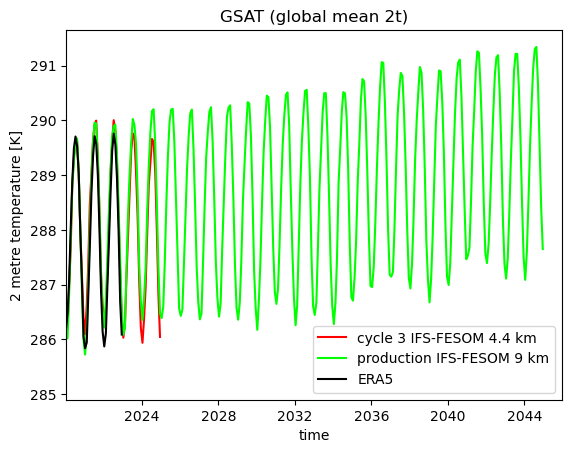

In [38]:
# quick plot, also adding some model simulations

# compute global mean 2t and plot time series:
cdo.fldmean(input=ifs_2t.to_dataset(), returnXDataset=True)['2t'].plot(color='red',label='cycle 3 IFS-FESOM 4.4 km')
cdo.fldmean(input=temp2_tco1279_prod_gm, returnXDataset=True)['mean2t'].plot(color='lime',label='production IFS-FESOM 9 km')
# cdo.fldmean(input=ifs_28km_f_2t.to_dataset(), returnXDataset=True)['2t'].plot(color='magenta',label='IFS 28 km FESOM')
# cdo.fldmean(input=ifs_9km_f_2t.to_dataset(), returnXDataset=True)['2t'].plot(color='tomato',label='IFS 9 km FESOM')
# icon_5km_2t_gm.plot(color='green',label='ICON 5km')

era5_gm.plot(color='black',label='ERA5')
plt.xlim([pd.to_datetime('2020-01-15'),pd.to_datetime('2045-12-15')]) # use this to limit x-axis to model simulations
plt.title('GSAT (global mean 2t)')
plt.legend()
plt.savefig(plotdir + 'GSAT_global_mean_production.png')

---
## plotting
### global mean time series

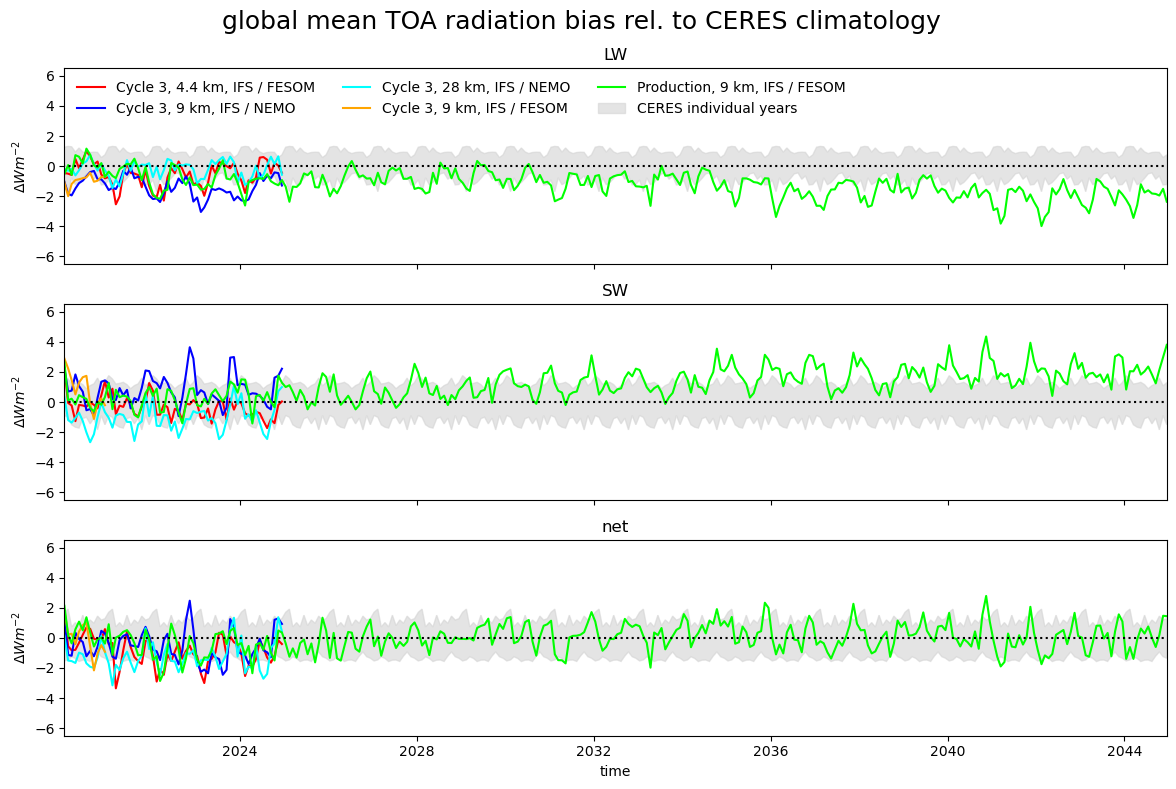

In [41]:
fig, axes = plt.subplots(3, 1,figsize=(12,8))
linecolors = ['red',
              'blue',
              'cyan',
              # 'green',
              # 'magenta',
              'orange',
              'lime'

             ]
linelabels = ['Cycle 3, 4.4 km, IFS / FESOM',
              'Cycle 3, 9 km, IFS / NEMO',
              'Cycle 3, 28 km, IFS / NEMO',
              # 'Cycle 3, 5 km, ICON',
              # 'Cycle 3, 28 km, IFS / FESOM',
              'Cycle 3, 9 km, IFS / FESOM',
              'Production, 9 km, IFS / FESOM',
             ]
models = [TOA_ifs_gm.squeeze(),
          TOA_ifs_9km_gm.squeeze(),
          TOA_ifs_28km_gm.squeeze(),
          # TOA_icon_5km_gm.squeeze(),
          # TOA_ifs_28km_f_gm.squeeze(),
          TOA_ifs_9km_f_gm.squeeze(),
          TOA_tco1279_prod_gm.squeeze(),
         ]


# duplicate CERES IV sampels and concatenate years to plot one connected envelope for IV uncertainty
shading_data = xr.concat((TOA_ceres_diff_samples_gm, 
                          TOA_ceres_diff_samples_gm.assign_coords(time=models[4].ttr.sel(time='2021').time),
                          TOA_ceres_diff_samples_gm.assign_coords(time=models[4].ttr.sel(time='2022').time),
                          TOA_ceres_diff_samples_gm.assign_coords(time=models[4].ttr.sel(time='2023').time),
                          TOA_ceres_diff_samples_gm.assign_coords(time=models[4].ttr.sel(time='2024').time),
                          TOA_ceres_diff_samples_gm.assign_coords(time=models[4].ttr.sel(time='2025').time),
                          TOA_ceres_diff_samples_gm.assign_coords(time=models[4].ttr.sel(time='2026').time),
                          TOA_ceres_diff_samples_gm.assign_coords(time=models[4].ttr.sel(time='2027').time),
                          TOA_ceres_diff_samples_gm.assign_coords(time=models[4].ttr.sel(time='2028').time),
                          TOA_ceres_diff_samples_gm.assign_coords(time=models[4].ttr.sel(time='2029').time),
                          TOA_ceres_diff_samples_gm.assign_coords(time=models[4].ttr.sel(time='2030').time),
                          TOA_ceres_diff_samples_gm.assign_coords(time=models[4].ttr.sel(time='2031').time),
                          TOA_ceres_diff_samples_gm.assign_coords(time=models[4].ttr.sel(time='2032').time),
                          TOA_ceres_diff_samples_gm.assign_coords(time=models[4].ttr.sel(time='2033').time),          
                          TOA_ceres_diff_samples_gm.assign_coords(time=models[4].ttr.sel(time='2034').time),
                          TOA_ceres_diff_samples_gm.assign_coords(time=models[4].ttr.sel(time='2035').time),
                          TOA_ceres_diff_samples_gm.assign_coords(time=models[4].ttr.sel(time='2036').time),
                          TOA_ceres_diff_samples_gm.assign_coords(time=models[4].ttr.sel(time='2037').time),
                          TOA_ceres_diff_samples_gm.assign_coords(time=models[4].ttr.sel(time='2038').time),
                          TOA_ceres_diff_samples_gm.assign_coords(time=models[4].ttr.sel(time='2039').time),                  
                          TOA_ceres_diff_samples_gm.assign_coords(time=models[4].ttr.sel(time='2040').time),   
                          TOA_ceres_diff_samples_gm.assign_coords(time=models[4].ttr.sel(time='2041').time),
                          TOA_ceres_diff_samples_gm.assign_coords(time=models[4].ttr.sel(time='2042').time),
                          TOA_ceres_diff_samples_gm.assign_coords(time=models[4].ttr.sel(time='2043').time),
                          TOA_ceres_diff_samples_gm.assign_coords(time=models[4].ttr.sel(time='2044').time),         
                          #TOA_ceres_diff_samples_gm.assign_coords(time=models[4].ttr.sel(time='2045').time),  
                          #TOA_ceres_diff_samples_gm.assign_coords(time=models[4].ttr.sel(time='2046').time), 
                          #TOA_ceres_diff_samples_gm.assign_coords(time=models[4].ttr.sel(time='2047').time),  
                          #TOA_ceres_diff_samples_gm.assign_coords(time=models[4].ttr.sel(time='2048').time), 
                          #TOA_ceres_diff_samples_gm.assign_coords(time=models[4].ttr.sel(time='2049').time),                          
                         ),dim='time' )
long_time=np.append(shading_data['time'],shading_data['time'][::-1])


# panel a

for i,model in enumerate(models):
    if len(model.time)==60:
        xr.concat(((model.ttr.sel(time='2020')-TOA_ceres_clim_gm.squeeze().ttr.values),
                   (model.ttr.sel(time='2021')-TOA_ceres_clim_gm.squeeze().ttr.values),
                   (model.ttr.sel(time='2022')-TOA_ceres_clim_gm.squeeze().ttr.values),
                   (model.ttr.sel(time='2023')-TOA_ceres_clim_gm.squeeze().ttr.values),
                   (model.ttr.sel(time='2024')-TOA_ceres_clim_gm.squeeze().ttr.values),
                ),dim='time').plot(ax=axes[0],color=linecolors[i],label=linelabels[i],x='time')
    elif len(model.time)>=60:
        xr.concat(((model.ttr.sel(time='2020')-TOA_ceres_clim_gm.squeeze().ttr.values),
                   (model.ttr.sel(time='2021')-TOA_ceres_clim_gm.squeeze().ttr.values),
                   (model.ttr.sel(time='2022')-TOA_ceres_clim_gm.squeeze().ttr.values),
                   (model.ttr.sel(time='2023')-TOA_ceres_clim_gm.squeeze().ttr.values),
                   (model.ttr.sel(time='2024')-TOA_ceres_clim_gm.squeeze().ttr.values),
                   (model.ttr.sel(time='2025')-TOA_ceres_clim_gm.squeeze().ttr.values),
                   (model.ttr.sel(time='2026')-TOA_ceres_clim_gm.squeeze().ttr.values),
                   (model.ttr.sel(time='2027')-TOA_ceres_clim_gm.squeeze().ttr.values),
                   (model.ttr.sel(time='2028')-TOA_ceres_clim_gm.squeeze().ttr.values),
                   (model.ttr.sel(time='2029')-TOA_ceres_clim_gm.squeeze().ttr.values),
                   (model.ttr.sel(time='2030')-TOA_ceres_clim_gm.squeeze().ttr.values),
                   (model.ttr.sel(time='2031')-TOA_ceres_clim_gm.squeeze().ttr.values),
                   (model.ttr.sel(time='2032')-TOA_ceres_clim_gm.squeeze().ttr.values),
                   (model.ttr.sel(time='2033')-TOA_ceres_clim_gm.squeeze().ttr.values), 
                   (model.ttr.sel(time='2034')-TOA_ceres_clim_gm.squeeze().ttr.values),
                   (model.ttr.sel(time='2035')-TOA_ceres_clim_gm.squeeze().ttr.values),
                   (model.ttr.sel(time='2036')-TOA_ceres_clim_gm.squeeze().ttr.values),
                   (model.ttr.sel(time='2037')-TOA_ceres_clim_gm.squeeze().ttr.values),    
                   (model.ttr.sel(time='2038')-TOA_ceres_clim_gm.squeeze().ttr.values),
                   (model.ttr.sel(time='2039')-TOA_ceres_clim_gm.squeeze().ttr.values),           
                   (model.ttr.sel(time='2040')-TOA_ceres_clim_gm.squeeze().ttr.values),       
                   (model.ttr.sel(time='2041')-TOA_ceres_clim_gm.squeeze().ttr.values),
                   (model.ttr.sel(time='2042')-TOA_ceres_clim_gm.squeeze().ttr.values),
                   (model.ttr.sel(time='2043')-TOA_ceres_clim_gm.squeeze().ttr.values),
                   (model.ttr.sel(time='2044')-TOA_ceres_clim_gm.squeeze().ttr.values),                   
                   #(model.ttr.sel(time='2045')-TOA_ceres_clim_gm.squeeze().ttr.values),                       
                   #(model.ttr.sel(time='2046')-TOA_ceres_clim_gm.squeeze().ttr.values),                       
                   #(model.ttr.sel(time='2047')-TOA_ceres_clim_gm.squeeze().ttr.values),                       
                   #(model.ttr.sel(time='2048')-TOA_ceres_clim_gm.squeeze().ttr.values),                       
                   #(model.ttr.sel(time='2049')-TOA_ceres_clim_gm.squeeze().ttr.values),                                           
                ),dim='time').plot(ax=axes[0],color=linecolors[i],label=linelabels[i],x='time')
    else:
        xr.concat((model.ttr.sel(time='2020')-TOA_ceres_clim_gm.squeeze().ttr.values),
          dim='time').plot(ax=axes[0],color=linecolors[i],label=linelabels[i],x='time')

axes[0].fill(long_time,np.append(shading_data['ttr'].min(dim='ensemble'),shading_data['ttr'].max(dim='ensemble')[::-1]),color='lightgrey',alpha=0.6,label='CERES individual years',zorder=0)


axes[0].set_title('LW',fontsize=16)
axes[0].set_xticklabels([])
axes[0].set_xlabel('')
axes[0].legend(loc="upper left",frameon=False,fontsize='medium',ncol=3)

# # # panel b
for i,model in enumerate(models):
    if len(model.time)==60:
        xr.concat(((model.tsr.sel(time='2020')-TOA_ceres_clim_gm.squeeze().tsr.values),
                   (model.tsr.sel(time='2021')-TOA_ceres_clim_gm.squeeze().tsr.values),
                   (model.tsr.sel(time='2022')-TOA_ceres_clim_gm.squeeze().tsr.values),
                   (model.tsr.sel(time='2023')-TOA_ceres_clim_gm.squeeze().tsr.values),
                   (model.tsr.sel(time='2024')-TOA_ceres_clim_gm.squeeze().tsr.values)),
                  dim='time').plot(ax=axes[1],color=linecolors[i],label=linelabels[i],x='time')
    elif len(model.time)>=60:
        xr.concat(((model.tsr.sel(time='2020')-TOA_ceres_clim_gm.squeeze().tsr.values),
                   (model.tsr.sel(time='2021')-TOA_ceres_clim_gm.squeeze().tsr.values),
                   (model.tsr.sel(time='2022')-TOA_ceres_clim_gm.squeeze().tsr.values),
                   (model.tsr.sel(time='2023')-TOA_ceres_clim_gm.squeeze().tsr.values),
                   (model.tsr.sel(time='2024')-TOA_ceres_clim_gm.squeeze().tsr.values),
                   (model.tsr.sel(time='2025')-TOA_ceres_clim_gm.squeeze().tsr.values),
                   (model.tsr.sel(time='2026')-TOA_ceres_clim_gm.squeeze().tsr.values),
                   (model.tsr.sel(time='2027')-TOA_ceres_clim_gm.squeeze().tsr.values),
                   (model.tsr.sel(time='2028')-TOA_ceres_clim_gm.squeeze().tsr.values),
                   (model.tsr.sel(time='2029')-TOA_ceres_clim_gm.squeeze().tsr.values),
                   (model.tsr.sel(time='2030')-TOA_ceres_clim_gm.squeeze().tsr.values),
                   (model.tsr.sel(time='2031')-TOA_ceres_clim_gm.squeeze().tsr.values),
                   (model.tsr.sel(time='2032')-TOA_ceres_clim_gm.squeeze().tsr.values),       
                   (model.tsr.sel(time='2033')-TOA_ceres_clim_gm.squeeze().tsr.values),     
                   (model.tsr.sel(time='2034')-TOA_ceres_clim_gm.squeeze().tsr.values),
                   (model.tsr.sel(time='2035')-TOA_ceres_clim_gm.squeeze().tsr.values),
                   (model.tsr.sel(time='2036')-TOA_ceres_clim_gm.squeeze().tsr.values),       
                   (model.tsr.sel(time='2037')-TOA_ceres_clim_gm.squeeze().tsr.values),    
                   (model.tsr.sel(time='2038')-TOA_ceres_clim_gm.squeeze().tsr.values),
                   (model.tsr.sel(time='2039')-TOA_ceres_clim_gm.squeeze().tsr.values),    
                   (model.tsr.sel(time='2040')-TOA_ceres_clim_gm.squeeze().tsr.values),   
                   (model.tsr.sel(time='2041')-TOA_ceres_clim_gm.squeeze().tsr.values),                    
                   (model.tsr.sel(time='2042')-TOA_ceres_clim_gm.squeeze().tsr.values),    
                   (model.tsr.sel(time='2043')-TOA_ceres_clim_gm.squeeze().tsr.values),    
                   (model.tsr.sel(time='2044')-TOA_ceres_clim_gm.squeeze().tsr.values),    
                   #(model.tsr.sel(time='2045')-TOA_ceres_clim_gm.squeeze().tsr.values),    
                   #(model.tsr.sel(time='2046')-TOA_ceres_clim_gm.squeeze().tsr.values),    
                   #(model.tsr.sel(time='2047')-TOA_ceres_clim_gm.squeeze().tsr.values),    
                   #(model.tsr.sel(time='2048')-TOA_ceres_clim_gm.squeeze().tsr.values),    
                   #(model.tsr.sel(time='2049')-TOA_ceres_clim_gm.squeeze().tsr.values),    
                ),dim='time').plot(ax=axes[1],color=linecolors[i],label=linelabels[i],x='time')
    else:
        xr.concat((model.tsr.sel(time='2020')-TOA_ceres_clim_gm.squeeze().tsr.values),
          dim='time').plot(ax=axes[1],color=linecolors[i],label=linelabels[i],x='time')


axes[1].fill(long_time,np.append(shading_data['tsr'].min(dim='ensemble'),shading_data['tsr'].max(dim='ensemble')[::-1]),color='lightgrey',alpha=0.6,label='CERES individual years',zorder=0)

axes[1].set_title('SW',fontsize=16)
axes[1].set_xticklabels([])
axes[1].set_xlabel('')

# # # panel c
for i,model in enumerate(models):
    if len(model.time)==60:
        xr.concat(((model.tnr.sel(time='2020')-TOA_ceres_clim_gm.squeeze().tnr.values),
                   (model.tnr.sel(time='2021')-TOA_ceres_clim_gm.squeeze().tnr.values),
                   (model.tnr.sel(time='2022')-TOA_ceres_clim_gm.squeeze().tnr.values),
                   (model.tnr.sel(time='2023')-TOA_ceres_clim_gm.squeeze().tnr.values),
                   (model.tnr.sel(time='2024')-TOA_ceres_clim_gm.squeeze().tnr.values)),
                  dim='time').plot(ax=axes[2],color=linecolors[i],label=linelabels[i],x='time')
    elif len(model.time)>=60:
        xr.concat(((model.tnr.sel(time='2020')-TOA_ceres_clim_gm.squeeze().tnr.values),
                   (model.tnr.sel(time='2021')-TOA_ceres_clim_gm.squeeze().tnr.values),
                   (model.tnr.sel(time='2022')-TOA_ceres_clim_gm.squeeze().tnr.values),
                   (model.tnr.sel(time='2023')-TOA_ceres_clim_gm.squeeze().tnr.values),
                   (model.tnr.sel(time='2024')-TOA_ceres_clim_gm.squeeze().tnr.values),
                   (model.tnr.sel(time='2025')-TOA_ceres_clim_gm.squeeze().tnr.values),
                   (model.tnr.sel(time='2026')-TOA_ceres_clim_gm.squeeze().tnr.values),
                   (model.tnr.sel(time='2027')-TOA_ceres_clim_gm.squeeze().tnr.values),
                   (model.tnr.sel(time='2028')-TOA_ceres_clim_gm.squeeze().tnr.values),
                   (model.tnr.sel(time='2029')-TOA_ceres_clim_gm.squeeze().tnr.values),
                   (model.tnr.sel(time='2030')-TOA_ceres_clim_gm.squeeze().tnr.values),
                   (model.tnr.sel(time='2031')-TOA_ceres_clim_gm.squeeze().tnr.values),
                   (model.tnr.sel(time='2032')-TOA_ceres_clim_gm.squeeze().tnr.values),      
                   (model.tnr.sel(time='2033')-TOA_ceres_clim_gm.squeeze().tnr.values),    
                   (model.tnr.sel(time='2034')-TOA_ceres_clim_gm.squeeze().tnr.values),
                   (model.tnr.sel(time='2035')-TOA_ceres_clim_gm.squeeze().tnr.values),
                   (model.tnr.sel(time='2036')-TOA_ceres_clim_gm.squeeze().tnr.values),      
                   (model.tnr.sel(time='2037')-TOA_ceres_clim_gm.squeeze().tnr.values),    
                   (model.tnr.sel(time='2038')-TOA_ceres_clim_gm.squeeze().tnr.values),
                   (model.tnr.sel(time='2039')-TOA_ceres_clim_gm.squeeze().tnr.values),
                   (model.tnr.sel(time='2040')-TOA_ceres_clim_gm.squeeze().tnr.values),      
                   (model.tnr.sel(time='2041')-TOA_ceres_clim_gm.squeeze().tnr.values), 
                   (model.tnr.sel(time='2042')-TOA_ceres_clim_gm.squeeze().tnr.values), 
                   (model.tnr.sel(time='2043')-TOA_ceres_clim_gm.squeeze().tnr.values), 
                   (model.tnr.sel(time='2044')-TOA_ceres_clim_gm.squeeze().tnr.values), 
                   #(model.tnr.sel(time='2045')-TOA_ceres_clim_gm.squeeze().tnr.values), 
                   #(model.tnr.sel(time='2046')-TOA_ceres_clim_gm.squeeze().tnr.values), 
                   #(model.tnr.sel(time='2047')-TOA_ceres_clim_gm.squeeze().tnr.values), 
                   #(model.tnr.sel(time='2048')-TOA_ceres_clim_gm.squeeze().tnr.values), 
                   #(model.tnr.sel(time='2049')-TOA_ceres_clim_gm.squeeze().tnr.values),  
                ),dim='time').plot(ax=axes[2],color=linecolors[i],label=linelabels[i],x='time')
    else:
        xr.concat((model.tnr.sel(time='2020')-TOA_ceres_clim_gm.squeeze().tnr.values),
          dim='time').plot(ax=axes[2],color=linecolors[i],label=linelabels[i],x='time')

axes[2].fill(long_time,np.append(shading_data['tnr'].min(dim='ensemble'),shading_data['tnr'].max(dim='ensemble')[::-1]),color='lightgrey',alpha=0.6,label='CERES individual years',zorder=0)
axes[2].set_title('net',fontsize=16)

for i in range(3):
    axes[i].set_ylabel('$W/m^2$')
    axes[i].set_xlim([pd.to_datetime('2020-01-15'),pd.to_datetime('2044-12-15')])
    axes[i].plot([pd.to_datetime('2020-01-01'),pd.to_datetime('2049-12-31')],[0,0],color='black',linestyle=':')
    axes[i].set_ylim([-6.5,6.5])


axes[0].set_title('LW')
axes[1].set_title('SW')
axes[2].set_title('net')

for i in range(3):
    axes[i].set_ylabel('$\Delta Wm^{-2}$')

plt.suptitle('global mean TOA radiation bias rel. to CERES climatology',fontsize=18)
plt.tight_layout()    

plt.savefig(plotdir + 'TOA_bias_clim_global_mean_production.png')

---

### Gregory plot
TOA net radiation imbalance (y-axis) vs global mean near-surface air temperature (GSAT) to compare imbalance and temperature to observations and analyse potential drift and equilibration

In [43]:
temp2_tco1279_prod_gm.squeeze()

<xarray.Dataset>
Dimensions:  (time: 300)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-15 2020-02-15 ... 2044-12-15
    lon      float64 0.0
    lat      float64 0.0
Data variables:
    mean2t   (time) float64 286.0 286.0 286.8 287.8 ... 290.7 289.6 288.4 287.6
Attributes:
    CDI:          Climate Data Interface version 2.3.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Fri Mar 01 16:48:08 2024: cdo -O -s -f nc -fldmean /scratch...
    CDO:          Climate Data Operators version 2.3.0 (https://mpimet.mpg.de...

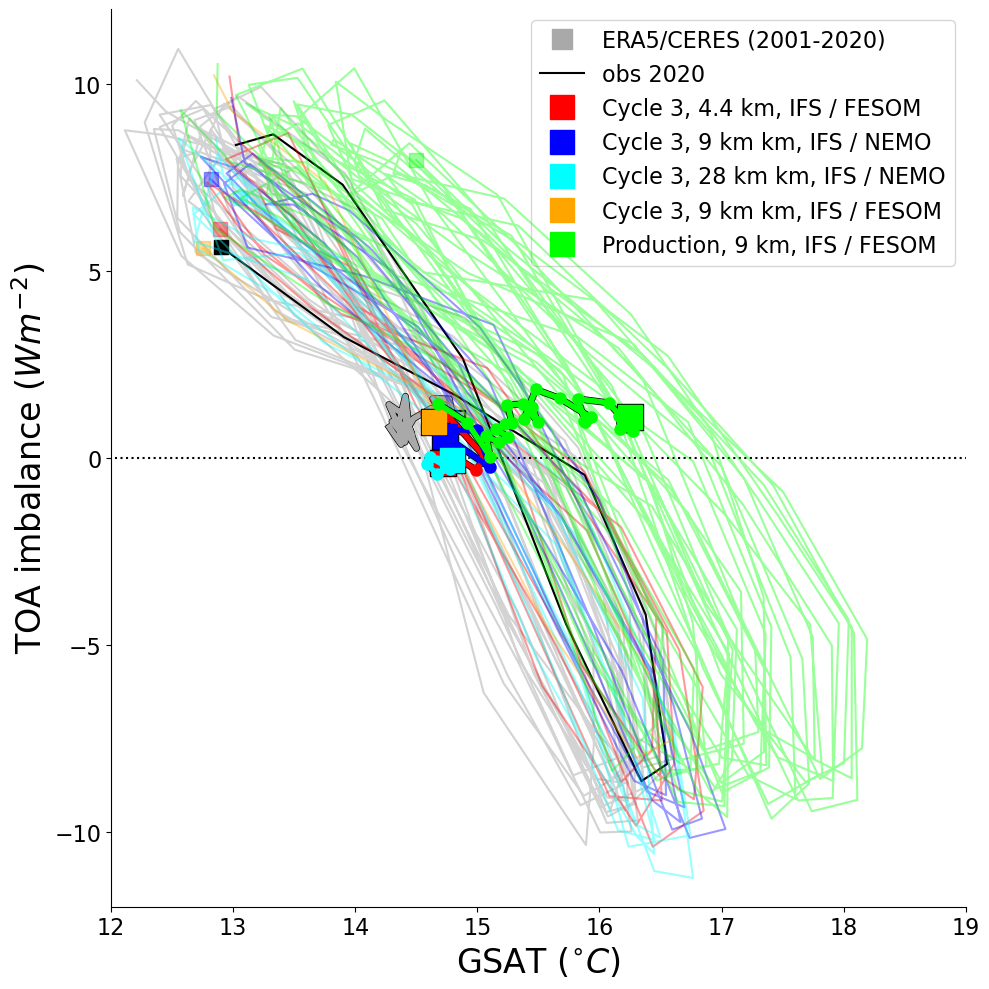

In [44]:
fig, ax = plt.subplots(figsize=(10,10))


linecolors = ['red',
              'blue',
              'cyan',
              # 'green',
              # 'magenta',
              'orange',
              # 'magenta',
              # 'indigo',
              'lime',
             ]
linelabels = ['Cycle 3, 4.4 km, IFS / FESOM',
              'Cycle 3, 9 km km, IFS / NEMO',
              'Cycle 3, 28 km km, IFS / NEMO',
              # 'Cycle 3, 5 km, ICON',
              # 'Cycle 3, 28 km km, IFS / FESOM',
              'Cycle 3, 9 km km, IFS / FESOM',
              # 'CMIP6 MPI-ESM-HR 2000-2014',
              # 'CMIP6 CanESM5 2000-2014',
              'Production, 9 km, IFS / FESOM',
             ]


models_toa = [TOA_ifs_gm.tnr.squeeze(),
              TOA_ifs_9km_gm.tnr.squeeze(),
              TOA_ifs_28km_gm.tnr.squeeze(),
              # TOA_icon_5km_gm.sel(time=slice('2020','2024')).tnr.squeeze(), # selecting 2020-2024 because 2025 is incomplete and the annual mean can't be computed
              # TOA_ifs_28km_f_gm.tnr.squeeze(),
              TOA_ifs_9km_f_gm.tnr.squeeze(),
              # MPI_ESM_HR_net.sel(time=slice('2000','2020')),
              # CanESM5_net.sel(time=slice('2000','2020')),
              TOA_tco1279_prod_gm.tnr.squeeze(), #.sel(time=slice('2040','2040'))
             ]
models_temp = [cdo.fldmean(input=ifs_2t.to_dataset(), returnXDataset=True)['2t'].squeeze()-273.15,
               cdo.fldmean(input=ifs_9km_2t.to_dataset(), returnXDataset=True)['2t'].squeeze()-273.15,
               cdo.fldmean(input=ifs_28km_2t.to_dataset(), returnXDataset=True)['2t'].squeeze()-273.15,
               # icon_5km_2t_gm.sel(time=slice('2020','2024'))-273.15,
               # cdo.fldmean(input=ifs_28km_f_2t.to_dataset(), returnXDataset=True)['2t'].squeeze()-273.15,
               cdo.fldmean(input=ifs_9km_f_2t.to_dataset(), returnXDataset=True)['2t'].squeeze()-273.15,
               # MPI_ESM_HR_GSAT.sel(time=slice('2000','2020')),
               # CanESM5_GSAT.sel(time=slice('2000','2020')),
              temp2_tco1279_prod_gm.to_array().squeeze()-273.15 #.sel(time=slice('2040','2040'))
              ]


small_fonts = 16
large_fonts = small_fonts*1.5
lw = 2

# obs
x=era5_gm.sel(time=slice('2001','2020')).squeeze()-273.15
y=TOA_ceres_ebaf_gm.tnr.sel(time=slice('2001','2020')).squeeze()
x_ym = x.groupby('time.year').mean(dim='time')
y_ym = y.groupby('time.year').mean(dim='time')
plt.plot(x,y,color='lightgrey',label='')
plt.plot(x_ym,y_ym,color='black',linewidth=5,label='')
plt.plot(x_ym,y_ym,color='darkgrey',linewidth=4,label='')
plt.plot(x_ym[-1],y_ym[-1],'s',markersize=17,color='black')
plt.plot(x_ym[-1],y_ym[-1],'s',markersize=15,color='darkgrey',label='ERA5/CERES (2001-2020)')
plt.plot(x[-1],y[-1],'s',markersize=10,color='lightgrey')

# obs 2020
x=era5_gm.sel(time='2020').squeeze()-273.15
y=TOA_ceres_ebaf_gm.tnr.sel(time='2020').squeeze()
x_ym = x.groupby('time.year').mean(dim='time')
y_ym = y.groupby('time.year').mean(dim='time')
plt.plot(x,y,color='black',label='obs 2020')
plt.plot(x[-1],y[-1],'s',markersize=10,color='black')


# plot all models from list:

for i,model in enumerate(models_toa):
    x=models_temp[i]
    y=models_toa[i]
    x_ym = x.groupby('time.year').mean(dim='time')
    y_ym = y.groupby('time.year').mean(dim='time')
    plt.plot(x,y,color=linecolors[i],label='',zorder=20, alpha=0.4) # thin line for monthly means
    plt.plot(x[-1],y[-1],'s',markersize=10,color=linecolors[i], alpha=0.4) # small square marking last monthly mean in simulation
    plt.plot(x_ym,y_ym,color='black',linewidth=5,label='',zorder=40) # solid line for annual means (black border)
    plt.plot(x_ym,y_ym,color=linecolors[i],linewidth=4,label='',zorder=41) # solid line for annual means
    plt.plot(x_ym,y_ym,'.',color=linecolors[i],markersize=16,label='',zorder=41) # dots for each annual mean

    plt.plot(x_ym[-1],y_ym[-1],'s',markersize=19,color='black',zorder=40) # large square for annual mean of the final year (black border)
    plt.plot(x_ym[-1],y_ym[-1],'s',markersize=17,color=linecolors[i],zorder=41,label=linelabels[i]) # large square for annual mean of the final year


TOA_tco1279_prod_gm    


plt.tick_params(axis='x', labelsize=small_fonts )
plt.tick_params(axis='y', labelsize=small_fonts )

plt.plot([0,25],[0,0],color='black',linestyle=':')
plt.ylabel('TOA imbalance ($Wm^{-2}$)',fontsize=large_fonts )

plt.xlabel('GSAT ($^{\circ}C$)',fontsize=large_fonts )

plt.legend(fontsize=small_fonts,loc='upper right')

# Hide the right and top spines
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

plt.xlim([12,19])
plt.ylim([-12,12])
plt.tight_layout()
plt.savefig(plotdir+'gregory_plot_production.png',dpi=500)